In [152]:
!pip install folium
!pip install geopy
import folium
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

# Scraping data from wikipedia

[Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [153]:
page_text = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(page_text)
table = soup.find('table')

In [154]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [155]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


### Check if df contains rows with Borouh == 'Not assigned'

In [156]:
print(df.Borough.unique())
df[df.Borough == 'Not assigned']  

['North York' 'Downtown Toronto' "Queen's Park" 'Etobicoke' 'Scarborough'
 'East York' 'York' 'East Toronto' 'West Toronto' 'East York/East Toronto'
 'Central Toronto' 'Mississauga' 'Downtown Toronto Stn A'
 'Etobicoke Northwest' 'East Toronto Business']


,PostalCode,Borough,Neighborhood


### Check if df contains not assigned Neighbourhood with Borough existing

In [157]:
if 'Not assigned' in df.Neighborhood.unique():
    print('contains')
else:
    print('df is okay')

df is okay


### Shape of created DataFrame

In [158]:
df.shape # shape of created DataFrame

(103, 3)

# Getting coordinates for each postal

In [159]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv') # opening dataset from cource because of failure with geocoder (
coordinates.columns

Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')

### Using merge to join two dataframes by postal code to get new dataframe with coordinates

In [160]:
new_df = pd.merge(df, coordinates, left_on='PostalCode', right_on='Postal Code').drop(columns=['Postal Code'])
new_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


# Creating maps to visualize my neighborhoods and to visualize how they cluster together

### Visualizing neighborhoods

In [161]:
from geopy.geocoders import Nominatim

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [162]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(new_df['Latitude'], new_df['Longitude'], new_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto

### Visualizing clusters

Index(['Latitude', 'Longitude'], dtype='object')


Text(0.5, 1.0, 'Elbow curve')

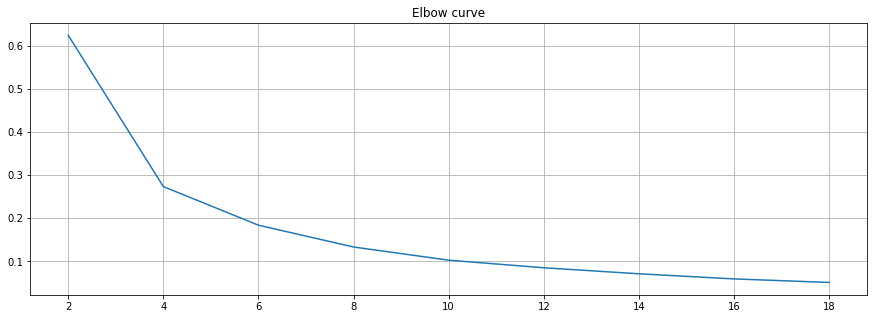

In [163]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

df_clustering = new_df.drop(columns=['PostalCode', 'Borough', 'Neighborhood'])

# run k-means clustering with using elbow method to get optimal count of clusters
distorsions = []
for k in range(2, 20, 2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_clustering)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20, 2), distorsions)
plt.grid(True)
plt.title('Elbow curve')

optimal cluster count is 6

In [166]:
optimal_kmeans = KMeans(n_clusters=6, random_state=0)
optimal_kmeans.fit(df_clustering)
new_df['cluster'] = optimal_kmeans.predict(df_clustering)

new_df.columns

Index(['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude',
       'cluster'],
      dtype='object')

In [169]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_df['Latitude'], new_df['Longitude'], new_df['Neighborhood'], new_df['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters